In [153]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2

from skimage import io
from nms_python import nms
from helper_function import generate_folder

result_root_dir = '/home/sh38/cell_counting/results'

subset = 'val'
method = 'unet'
# method = 'regnet'
# dataset = 'bacterial'
# dataset = 'bone_marrow'
# dataset = 'colorectal'
dataset = 'hESC'
cross = 1

# create a subfolder: result_root_dir/method/dataset/cross
result_dir = os.path.join(result_root_dir, method, dataset, 'cross-{}/{}'.format(cross, subset))
generate_folder(result_dir)

# read the prediction maps
pred_dir = os.path.join('./datasets',method, dataset, 'cross-{}/{}'.format(cross, subset))
image_dir = pred_dir +'/images'
dot_dir = pred_dir+'/dots'
gt_map_dir = pred_dir+'/masks'
pr_map_dir = pred_dir +'/pr_masks'

dot_fnames = os.listdir(dot_dir)
fnames = os.listdir(pr_map_dir)

images = [io.imread(image_dir+'/{}'.format(fname)) for fname in dot_fnames]
gt_maps = [io.imread(gt_map_dir+'/{}'.format(fname)) for fname in dot_fnames]
dot_maps = [io.imread(dot_dir+'/{}'.format(fname)) for fname in dot_fnames]
pr_maps = [np.load(pr_map_dir+'/{}'.format(fname.replace('png', 'npy'))) for fname in dot_fnames]

dot_maps = np.stack(dot_maps)
pr_maps = np.stack(pr_maps)

In [12]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    SMALL_SIZE = 24
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    return ax

434
78612
78612
78612
Detected centroids: 1294
(512, 512, 3)


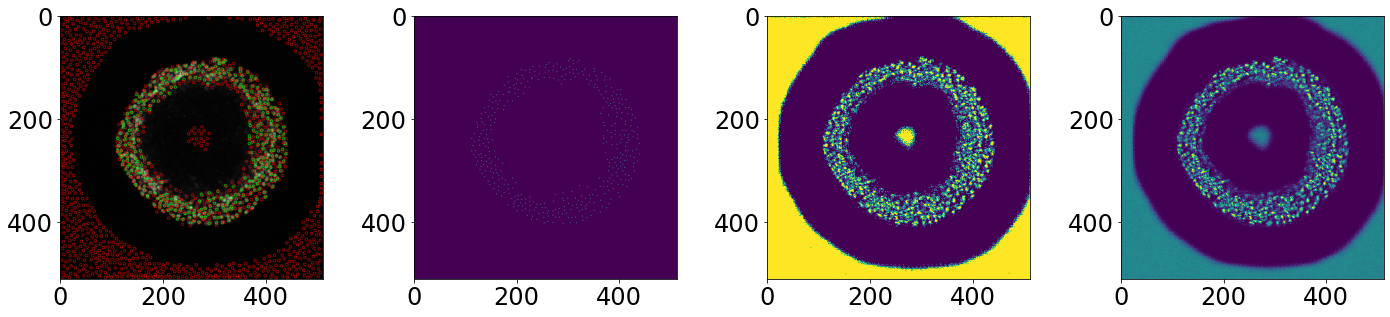

In [158]:
# non-maximum suppression
if method == 'regnet':
    if dataset == 'bacterial':
        radius = 4
        img_dim = 256
        hf_box_size = 7
        thickness = 1
        threshold = 0.27
    if dataset == 'bone_marrow':
        radius = 8
        img_dim = 600
        hf_box_size = 11
        thickness = 2
        threshold = 0.3
    if dataset == 'colorectal':
        radius = 5
        img_dim = 500
        hf_box_size = 11
        thickness = 2
        threshold = 0.3
    if dataset == 'hESC':
        radius = 3
        img_dim = 512
        hf_box_size = 7
        thickness = 1
        threshold = 0.25
elif method == 'unet':
    if dataset == 'bacterial':
        radius = 4
        img_dim = 256
        hf_box_size = 9
        thickness = 1
        threshold = 0.32
    if dataset == 'bone_marrow':
        radius = 8
        img_dim = 600
        hf_box_size = 25
        thickness = 2
        threshold = 0.3
    if dataset == 'colorectal':
        radius = 5
        img_dim = 500
        hf_box_size = 11
        thickness = 2
        threshold = 0.45
    if dataset == 'hESC':
        radius = 3
        img_dim = 512
        hf_box_size = 7
        thickness = 1
        threshold = 0.25    
        
img_idx = 1
image = images[img_idx].copy()
gt_map = gt_maps[img_idx]
dot_map = dot_maps[img_idx]
pr_map = pr_maps[img_idx]
ys, xs = np.where(dot_map>0)
print(len(ys))
# image = cv2.resize(image, (512,512))
for i in range(len(ys)):
    yi, xi = ys[i], xs[i]
    cv2.circle(image,(xi,yi),radius, color=(0,255,0), thickness= thickness)
#     cv2.circle(image,(xi*2,yi*2),radius*2, color=(0,255,0), thickness= thickness)
## non-maximum
from nms_python import nms
thres_mask = pr_map >threshold
pr_mask = pr_map
ys, xs = np.where(pr_mask>threshold)
print(len(xs))
bound_boxes = []
probs = []
for i in range(len(xs)):
    xi, yi = xs[i], ys[i]; #print(xi,yi)
    x1, x2, y1, y2 = max(0,xi-hf_box_size), min(img_dim,xi+hf_box_size), max(0,yi-hf_box_size), min(img_dim,yi+hf_box_size)
    probs.append(pr_mask[xi,yi])
    bound_boxes.append((x1, y1, x2, y2))
print(len(probs)); print(len(bound_boxes))
boxes = np.array(bound_boxes)
det_centroids = nms.non_max_suppression_fast(boxes, probs, overlapThresh=0.4)
print('Detected centroids: {}'.format(len(det_centroids)))
# image = images[index]; print(image.max())
# orig = image.copy(); print(orig.shape)
for (startX, startY, endX, endY) in det_centroids:
    xc, yc = int((endX+startX)/2), int((endY+startY)/2)
#     xc, yc = int((endX+startX)), int((endY+startY))
    cv2.circle(image,(xc,yc), radius, color=(255,0,0), thickness= thickness)
#     cv2.circle(image,(xc,yc), radius*2, color=(255,0,0), thickness= thickness)
ax = get_ax(1,4,5)
ax[0].imshow(image); ax[1].imshow(dot_map); ax[2].imshow(thres_mask); ax[3].imshow(pr_map)
io.imsave(result_dir+'/{}'.format(dot_fnames[img_idx]), image)
print(image.shape)